In [ ]:
!pip install category_encoders --quiet
!pip install pdpbox --quiet
!pip install shap --quiet

In [ ]:
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
import shap
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_poisson_deviance
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot


URL = 'https://raw.githubusercontent.com/yaobviously/DataCup2021/main/modifiedohl.csv'
shots_next_ten = pd.read_csv('https://raw.githubusercontent.com/yaobviously/DataCup2021/main/shotsnext10.csv',
                             index_col = 'game_date')

In [ ]:
def wrangle(URL):
  df = pd.read_csv(URL,
                   parse_dates = ['game_date'],
                   index_col = 'game_date')
  
  # dropping columns i made awhile ago that i don't need to build models, 
  # although they may be handy for communicating insights. all of the score
  # and player differentials can now, i see, be reduced to single columns for
  # the purposes of model building

  col_drop = ['Unnamed: 0', 'possSet', 'shots_next_ten', 'goal_next_ten', 
              '5on5', '5on4home', '5on3home', '5on4away', '5on3away', 
              '4on4', 'tie', 'home_ahead_1', 'home_ahead_2', 'home_ahead_3ormore',
              'away_ahead_1', 'away_ahead_2', 'away_ahead_3ormore', 'home_team',
              'away_team', 'x_coordinate_2', 'y_coordinate_2', 'is_shot', 'player_2']

  df = df.drop(columns = col_drop).copy()
  df = df.rename(columns = {'detail_3' : 'traffic', 'detail_4' : 'one_timer',
                            'detail_1' : 'event_detail', 'detail_2' : 'shot_result'})
  
  # condensing the above columns: i do not need columns for each man-adv state (duh)

  df['home_skater_adv'] = df['home_team_skaters'] - df['away_team_skaters']
  df['home_score_diff'] = df['home_team_goals'] - df['away_team_goals']
  df['is_shot'] = [1 if event in ['Goal', 'Shot'] else 0 for event in df['event']]

  # converting the clock column to the seconds remaining in the period in the
  # ugliest way imaginable
  
  df['min'] = df.clock.apply(lambda x: datetime.datetime.strptime(x,'%M:%S')).dt.minute
  df['sec'] = df.clock.apply(lambda x: datetime.datetime.strptime(x, '%M:%S')).dt.second
  df['period_sec_rem'] = df['min'] * 60 + df['sec']
  
  df.drop(columns = 'clock', inplace = True)

  # calculating the seconds remaining in the game, mostly for practice (needed!)

  def gamesecs(x):
  
    if x['period'] == 1:
      return x['period_sec_rem'] + 2400

    if x['period'] == 2:
      return x['period_sec_rem'] + 1200
  
    else:
      return x['period_sec_rem']

  df['game_sec_rem'] = df.apply(gamesecs, axis = 1)

  # creating new columns that contain info on prior game states

  df['x_coordinate_1back'] = df['x_coordinate'].shift()
  df['y_coordinate_1back'] = df['y_coordinate'].shift()
  df['x_coordinate_2back'] = df['x_coordinate'].shift(2)
  df['y_coordinate_2back'] = df['y_coordinate'].shift(2)
  df['event_1back'] = df['event'].shift()
  df['event_2back'] = df['event'].shift(2)

  df['sec_last_event'] = np.abs(df.groupby(['gameid', 'period'])['period_sec_rem'].diff())
  df['sec_2ndlast_event'] = np.abs(df.groupby(['gameid', 'period'])['period_sec_rem'].diff(2))

  # renaming a few descriptions so they're easier to understand

  df['event'] = (df['event']
                 .map({'Play' : 'Pass', 'Incomplete Play' : 'Incomplete Pass'})
                 .fillna(df['event']))

  # dropping redundant columns. 
  
  df.drop(columns = ['min', 'sec', 'is_shot'], inplace = True)

  # dropping columns with negligible importance. note 'team' & 'period may be 
  # useful for finding and creating useful (and non-leaky) features.

  lowimp_columns = ['away_team_goals', 'home_team_goals', 
                    'player', 'home_team_skaters', 'away_team_skaters', 'traffic',
                    'gameid', 'period', 'team', 'one_timer', 'is_goal', 'period_sec_rem']

  

  df.drop(lowimp_columns, axis = 1, inplace = True)

  # I used the below code to create a column counting the shots in the next 10
  # seconds of gameplay. because it takes so long to run, i decided to save it directly
  # to a new .csv file
  
  # sums = []
  # for game, period, sec in zip(df['gameid'], df['period'], df['period_sec_rem']):
    
  # sec_plus_10 = sec - 10  
  # mask = ((df['gameid'] == game) & \
  # (df['period'] == period) & \
  # (df['period_sec_rem'] >= sec_plus_10) & \
  # (df['period_sec_rem'] < sec))
  # sum_shots = df.loc[mask]['is_shot'].sum()
  # sums.append(sum_shots)

  # adding the shots in the next ten column
  df['shots_next_ten'] = shots_next_ten['shots_next_10']
  

  return df

In [ ]:
df = wrangle(URL)

In [ ]:
target = 'shots_next_ten'

train_threshold = '2020-01-15'
test_threshold = '2020-02-13'

mask = df.index < train_threshold
mask2 = df.index > test_threshold

X = df.drop(target, axis = 1)
y = df[target]

X_train, y_train = X[mask], y[mask]
X_val, y_val = X[~mask & ~mask2], y[~mask & ~mask2]
X_test, y_test = X[mask2], y[mask2]

In [ ]:
naive_pred_train = [y_train.mean()] * len(y_train)
baseline_MAE_train = mean_absolute_error(y_train, naive_pred_train)
baseline_poisson_deviance = mean_poisson_deviance(y_train, naive_pred_train)
print('The mean absolute error of our naive estimator is:', baseline_MAE_train)
print('The baseline Poisson deviance is:', baseline_poisson_deviance)

The mean absolute error of our naive estimator is: 0.5034843933841647
The baseline Poisson deviance is: 0.9052658453895543


In [ ]:
# creating the XGB Regressor model. note that i specify the objective as a count!

booster = XGBRegressor(objective = 'count:poisson',
                       n_estimators = 125,
                       max_depth = 3)

booster.feature_names = list(X.columns)


model_xg = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy = 'median'),
    booster)


model_xg.fit(X_train, y_train)

In [ ]:
# hyperparameter tuning the XGBoost model

xgb_reg_params = {
    'xgbregressor__max_depth': [n for n in np.arange(1,5,1)],
    'xgbregressor__n_estimators' : [n for n in np.arange(25,500,25)]
}

xgb_search = RandomizedSearchCV(model_xg,
                                param_distributions = xgb_reg_params,
                                scoring = 'neg_mean_poisson_deviance')

xgb_search.fit(X_val, y_val)

In [ ]:
print('The best Poisson deviance achieved through the random search of model params was:', abs(xgb_search.best_score_))

The best Poisson deviance achieved through the random search of model params was: 0.8184132711585959


In [ ]:
# looking at the metrics for my optimized XGB Regressor model on the validation set. it 
# does appear to have improved upon the baseline

model_MAE = mean_absolute_error(y_val, model_xg.predict(X_val))
model_rsquared = model_xg.score(X_val, y_val)
model_poisson_deviance = mean_poisson_deviance(y_val, model_xg.predict(X_val))

print('The MAE of my first model is:', model_MAE)

print('The R Squared of my first model is:', model_rsquared)

print('The model Poisson deviance is:', model_poisson_deviance)

The MAE of my first model is: 0.4512510154883278
The R Squared of my first model is: 0.07856396818149936
The model Poisson deviance is: 0.8181166202088829


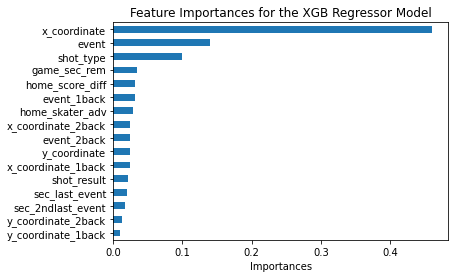

In [ ]:
features = model_xg.named_steps['ordinalencoder'].get_feature_names()
feature_importances = model_xg.named_steps['xgbregressor'].feature_importances_

feature_series = pd.Series(feature_importances, index = features).sort_values()

feature_series.plot.barh()
plt.title('Feature Importances for the XGB Regressor Model')
plt.xlabel('Importances')
plt.show();

In [ ]:
perm_imp_regressor = permutation_importance(model_xg, X_val, y_val, n_repeats = 5)

perm_dict = {
    'importance_mean' : perm_imp_regressor['importances_mean'],
    'importance_std' : perm_imp_regressor['importances_std']
}

perm_df = pd.DataFrame(perm_dict, index = features)
perm_df;

In [ ]:
# plotting the feature importances using the XGB 'plot_importance' function

xgb_weight = plot_importance(model_xg.named_steps['xgbregressor'],
                             importance_type = 'weight',
                             title = 'Feature Importances: Weight'
                             
                             )

In [ ]:
print(f'The three features that appear most often in a tree within the ensemble are {X.columns[7]}, {X.columns[0]}, and {X.columns[1]}')


The three features that appear most often in a tree within the ensemble are game_sec_rem, event, and x_coordinate


The three features with the largest gain when they appear in a tree are x_coordinate, event, and shot_type


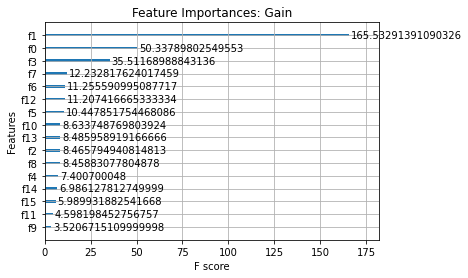

In [ ]:
xgb_gain = plot_importance(model_xg.named_steps['xgbregressor'],
                            importance_type = 'gain',
                            title = 'Feature Importances: Gain')


In [ ]:
print(f'The three features with the largest gain when they appear in a tree are {X.columns[1]}, {X.columns[0]}, and {X.columns[3]}')

In [ ]:
# replicating the pipeline model in a way that makes it legible to SHAP

encoder = OrdinalEncoder()
imputer = SimpleImputer()

X_train_encoded = encoder.fit_transform(X_train)
X_train_imputed = imputer.fit_transform(train_encoded)

shap_model = booster.fit(X_train_imputed, y_train)

In [ ]:
# transforming the test set in a way that makes it legible to SHAP

X_test_encoded = encoder.fit_transform(X_test)
X_test_imputed = imputer.fit_transform(X_test_encoded)
X_test_SHAPdf = pd.DataFrame(X_test_imputed, columns = X_test.columns)

explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test_imputed)

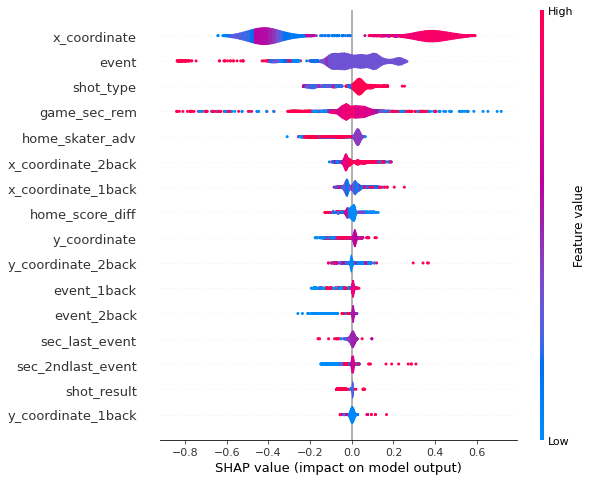

In [ ]:
# finally plotting the SHAP values on the test set

shap.summary_plot(shap_values, X_test_SHAPdf, plot_type = 'violin')

In [ ]:
# plotting a dependence plot for <> and <>

shap.dependence_plot('x_coordinate',
                     shap_values,
                     X_test_SHAPdf,
                     interaction_index = 'event',
                     title = 'Interaction Plot',
                     show = False,
                     alpha = 0.5,
                     )


plt.savefig('scorediff.png');